<a href="https://colab.research.google.com/github/NickolaiTheek/Age-and-Gender-Prediction/blob/main/Age_and_Gender_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
jangedoo_utkface_new_path = kagglehub.dataset_download('jangedoo/utkface-new')

print('Data source import complete.')

100%|██████████| 331M/331M [00:02<00:00, 157MB/s]

Extracting files...


Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
print(jangedoo_utkface_new_path)

/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


In [ ]:
BASE_DIR = '/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace'

In [ ]:
import os

# Verify if the directory exists
print("Directory exists:", os.path.exists(BASE_DIR))

# List files in the directory
print("Files in directory:", os.listdir(BASE_DIR)[:10])  # List first 10 files

Directory exists: True
Files in directory: ['50_0_3_20170117153047475.jpg.chip.jpg', '24_0_4_20170116232936514.jpg.chip.jpg', '34_1_1_20170113001446387.jpg.chip.jpg', '26_1_0_20170117153717556.jpg.chip.jpg', '30_0_0_20170117143444827.jpg.chip.jpg', '57_0_3_20170119211458431.jpg.chip.jpg', '25_1_0_20170116001327790.jpg.chip.jpg', '26_1_2_20170116180228453.jpg.chip.jpg', '29_1_1_20170113005659333.jpg.chip.jpg', '24_1_3_20170104222401271.jpg.chip.jpg']


In [ ]:
import os
from tqdm import tqdm

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    # Skip hidden files like non-JPG
    if filename.startswith('.') or not filename.lower().endswith('.jpg'):
        continue

    # Remove ".jpg" extension
    name, ext = os.path.splitext(filename)  # e.g. ("1_0_0_20161219...", ".jpg")
    parts = name.split('_')                 # e.g. ["1", "0", "0", "20161219..."]

    # Skip if we don't have at least 4 parts
    if len(parts) < 4:
        continue

    try:
        age = int(parts[0])
        gender = int(parts[1])
        ethnicity = int(parts[2])

    except ValueError:
        # If something isn’t integer, skip it
        continue

    # If we got here, we have valid data
    image_paths.append(os.path.join(BASE_DIR, filename))
    age_labels.append(age)
    gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 206618.71it/s]


In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,50,0
1,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,24,0
2,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,34,1
3,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,26,1
4,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,30,0


In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

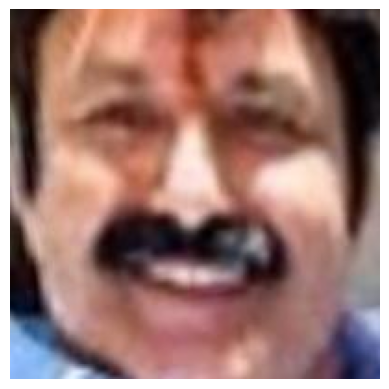

In [ ]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(df['image'][0])
plt.imshow(img)
plt.axis('off')
plt.show()

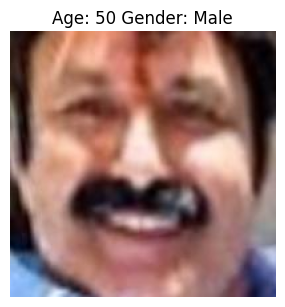

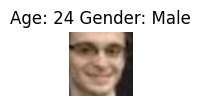

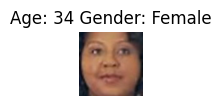

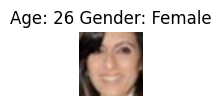

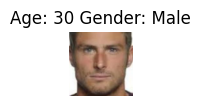

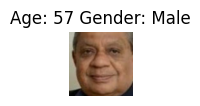

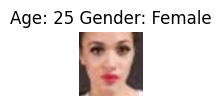

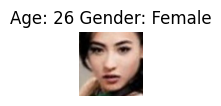

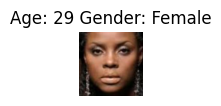

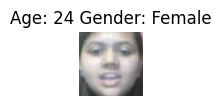

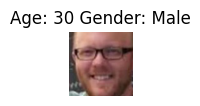

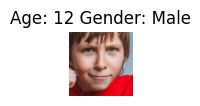

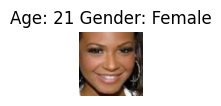

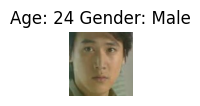

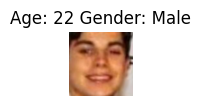

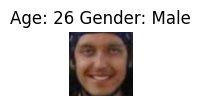

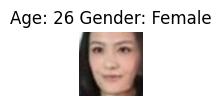

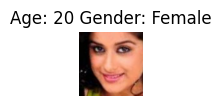

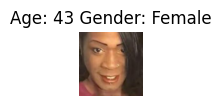

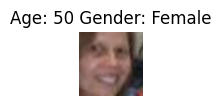

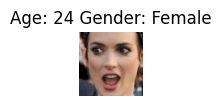

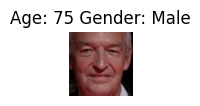

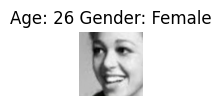

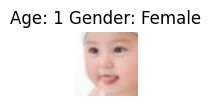

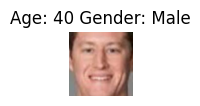

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')
    plt.show()

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)

    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
# Prepare the feature array (X) by processing images
X = extract_features(df['image'])

100%|██████████| 23705/23705 [00:38<00:00, 623.34it/s]


In [ ]:
# normalize the images
X = X/255.0

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you have already created the lists:
# image_paths, age_labels, gender_labels

# Convert labels to NumPy arrays
y_gender = np.array(gender_labels)
y_age = np.array(age_labels)

# # Prepare the feature array (X) by processing images
# X = extract_features(image_paths)  # Ensure `extract_features` is defined
# X = X / 255.0  # Normalize the image data

# Now split the data into training and testing sets
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42
)

# Check the shapes of the resulting datasets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape (Gender, Age):", y_gender_train.shape, y_age_train.shape)
print("Testing labels shape (Gender, Age):", y_gender_test.shape, y_age_test.shape)

Training data shape: (18964, 128, 128, 1)
Testing data shape: (4741, 128, 128, 1)
Training labels shape (Gender, Age): (18964,) (18964,)
Testing labels shape (Gender, Age): (4741,) (4741,)


In [ ]:
# from keras.models import Model
# from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

# # Define the input shape
# input_shape = (128, 128, 1)  # Adjust if using grayscale (1 channel) or RGB (3 channels)

# # Define the model
# inputs = Input((input_shape))

# # Convolutional layers
# conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
# maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
# conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
# maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
# conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
# maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
# conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
# maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

# # Flatten
# flatten = Flatten()(maxp_4)

# # Fully connected layers
# dense_1 = Dense(256, activation='relu')(flatten)
# dense_2 = Dense(256, activation='relu')(flatten)

# dropout_1 = Dropout(0.4)(dense_1)
# dropout_2 = Dropout(0.4)(dense_2)

# # Output layers
# output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)  # Gender classification
# output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)        # Age regression

# # Compile the model
# model = Model(inputs=[inputs], outputs=[output_1, output_2])
# model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

# # Summary of the model
# # model.summary()



In [ ]:
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the input shape
input_shape = (128, 128, 1)  # Adjust if using grayscale (1 channel) or RGB (3 channels)

# Define the model
inputs = Input((input_shape))

# Convolutional layers with Batch Normalization and L2 Regularization
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
bn_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(bn_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(maxp_1)
bn_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(bn_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(maxp_2)
bn_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(bn_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(maxp_3)
bn_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(bn_4)

# Flatten
flatten = Flatten()(maxp_4)

# Fully connected layers with Dropout and L2 Regularization
dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(flatten)
dropout_1 = Dropout(0.3)(dense_1)

dense_2 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dropout_1)
dropout_2 = Dropout(0.3)(dense_2)

# Output layers
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_2)  # Gender classification
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)        # Age regression

# Compile the model with a reduced learning rate
model = Model(inputs=[inputs], outputs=[output_1, output_2])
model.compile(
    loss=['binary_crossentropy', 'mae'],
    optimizer=Adam(learning_rate=0.0001),
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

# Add callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    x=X_train,
    y=[y_gender_train, y_age_train],
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
evaluation = model.evaluate(X_test, [y_gender_test, y_age_test], verbose=1)
print("Test Gender Loss:", evaluation[1])
print("Test Age Loss:", evaluation[2])
print("Test Gender Accuracy:", evaluation[3])
print("Test Age MAE:", evaluation[4])

Epoch 1/50
 68/475 ━━━━━━━━━━━━━━━━━━━━ 11:11 2s/step - age_out_loss: 20.5423 - age_out_mae: 20.5423 - gender_out_accuracy: 0.5554 - gender_out_loss: 1.1622 - loss: 22.7586

KeyboardInterrupt: 

In [ ]:
# # Train the model
# history = model.fit(
#     x=X_train,
#     y=[y_gender_train, y_age_train],
#     batch_size=32,
#     epochs=100,
#     validation_split=0.2  # Further split training data into training and validation
# )

In [ ]:
# Evaluate the model on the test set
test_loss, gender_loss, age_loss, gender_accuracy, age_mae = model.evaluate(
    X_test, [y_gender_test, y_age_test], verbose=1
)

# Print the results
print("Test Gender Loss:", gender_loss)
print("Test Age Loss:", age_loss)
print("Test Gender Accuracy:", gender_accuracy)
print("Test Age MAE:", age_mae)

In [ ]:
image_index = 1118
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Path to the image in the same folder
image_path = "/content/drive/MyDrive/22_0_0_20170111195452025.jpg"  # Image name

# Preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(128, 128))  # Load and resize the image
    img_array = img_to_array(img)  # Convert to NumPy array
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Load and preprocess the image
external_image = preprocess_image(image_path)

# Predict using the trained model
pred = model.predict(external_image)
pred_gender = gender_dict[round(float(pred[0][0]))]  # Gender prediction
pred_age = round(float(pred[1][0]))  # Age prediction

# Display the results
print("Predicted Gender:", pred_gender)
print("Predicted Age:", pred_age)

# Display the image
plt.axis('off')
plt.imshow(load_img(image_path, color_mode='grayscale'), cmap='gray')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy for Gender Prediction
plt.figure(figsize=(12, 6))
plt.plot(history.history['gender_out_accuracy'], label='Training Accuracy (Gender)')
plt.plot(history.history['val_gender_out_accuracy'], label='Validation Accuracy (Gender)')
plt.title('Accuracy vs. Epochs (Gender)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation MAE for Age Prediction
plt.figure(figsize=(12, 6))
plt.plot(history.history['age_out_mae'], label='Training MAE (Age)')
plt.plot(history.history['val_age_out_mae'], label='Validation MAE (Age)')
plt.title('MAE vs. Epochs (Age)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions for gender classification
y_gender_proba = model.predict(X_test)[0].flatten()  # Probabilities
y_gender_pred = (y_gender_proba > 0.5).astype(int)   # Convert probabilities to binary predictions

# Classification Report
print("Classification Report for Gender Prediction (Test Set):")
print(classification_report(y_gender_test, y_gender_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_gender_test, y_gender_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title("Confusion Matrix for Gender Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_gender_test, y_gender_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title("ROC Curve for Gender Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Summary Table (Accuracy, Precision, Recall, F1, AUC)
accuracy = np.mean(y_gender_test == y_gender_pred)
precision = np.sum((y_gender_pred == 1) & (y_gender_test == 1)) / np.sum(y_gender_pred == 1)
recall = np.sum((y_gender_pred == 1) & (y_gender_test == 1)) / np.sum(y_gender_test == 1)
f1 = 2 * (precision * recall) / (precision + recall)

print("\nSummary Table:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print(f"AUC: {roc_auc * 100:.2f}%")